In [2]:
import pandas as pd

# Cargar el archivo
file_path = './data/orders_orders.xlsx'
df = pd.read_excel(file_path)

# Ver rango de fechas
print("Rango de fechas:", df['Order Date'].min(), "a", df['Order Date'].max())

Rango de fechas: 2011-01-01 00:00:00 a 2014-12-31 00:00:00


In [3]:
# Agregar la columna 'Week' basada en la fecha
df['Year'] = df['Order Date'].dt.year
df['Week'] = df['Order Date'].dt.isocalendar().week

# Resumir las ventas por semana
df_weekly = df.groupby(['Year', 'Week'])['Sales'].sum().reset_index()

# Separar en train (2011-2013) y test (2014)
train = df_weekly[df_weekly['Year'] < 2014]
test = df_weekly[df_weekly['Year'] == 2014]



In [4]:
# Crear una lista con todas las combinaciones de año y semana
all_weeks = [(year, week) for year in range(2011, 2015) for week in range(1, 53)]

# Crear un DataFrame con todas las combinaciones posibles de año y semana
weeks_df = pd.DataFrame(all_weeks, columns=['Year', 'Week'])

# Unir con los datos agregados, completando los valores faltantes
df_weekly_full = pd.merge(weeks_df, df_weekly, on=['Year', 'Week'], how='left').fillna(0)


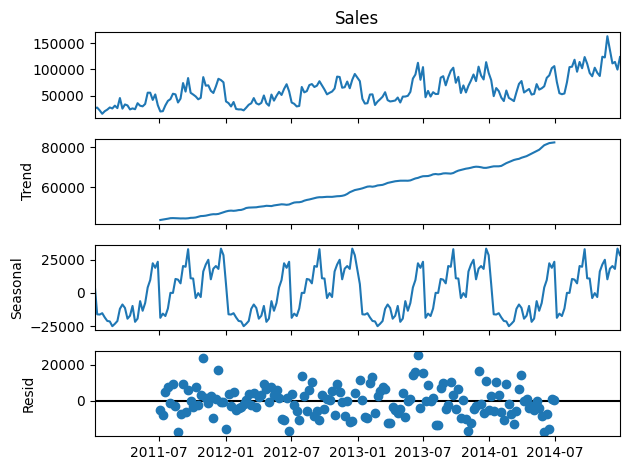

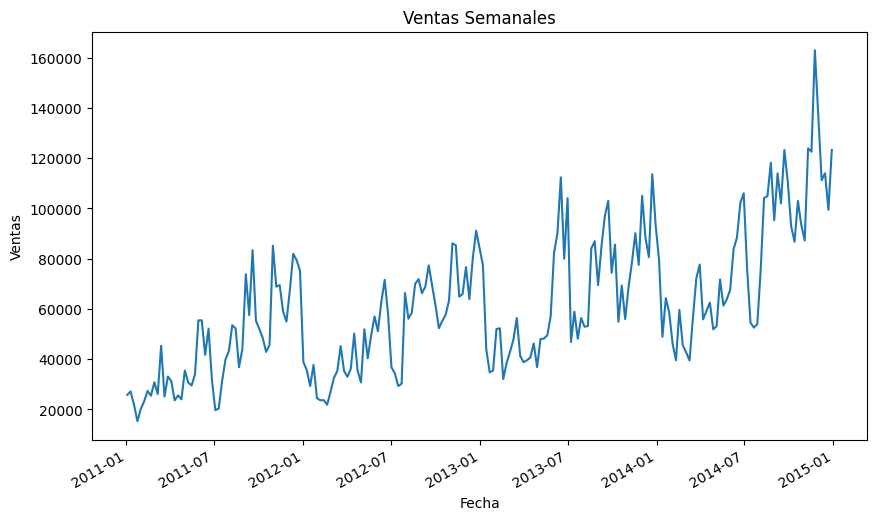

In [5]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd

# Crear la columna 'Date' con el primer día de cada semana
# Para esto, concatenamos el año y la semana y usamos pd.to_datetime con formato adecuado
df_weekly_full['Date'] = pd.to_datetime(df_weekly_full['Year'].astype(str) + df_weekly_full['Week'].astype(str) + '1', format='%Y%W%w')

# Establecer 'Date' como índice
df_weekly_full.set_index('Date', inplace=True)

# Descomposición de la serie temporal (estacionalidad, tendencia)
decomposition = sm.tsa.seasonal_decompose(df_weekly_full['Sales'], model='additive', period=52)
decomposition.plot()
plt.show()

# Visualización de la serie temporal completa
df_weekly_full['Sales'].plot(figsize=(10,6))
plt.title("Ventas Semanales")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.show()





In [6]:
from statsmodels.tsa.stattools import adfuller

# Función para comprobar estacionariedad
def check_stationarity(series):
    result = adfuller(series)
    return result[0], result[1]

# Realizar diferenciación si es necesario y comprobar la estacionariedad
# Differenciación de primer orden para entrenamiento
train_diff = train['Sales'].diff().dropna()

# Test ADF para el conjunto de train después de diferenciación
adf_train = check_stationarity(train_diff)
print(f"ADF Test Train (diferenciado): estadístico={adf_train[0]}, p-valor={adf_train[1]}")

# Differenciación de primer orden para test
test_diff = test['Sales'].diff().dropna()

# Test ADF para el conjunto de test después de diferenciación
adf_test = check_stationarity(test_diff)
print(f"ADF Test Test (diferenciado): estadístico={adf_test[0]}, p-valor={adf_test[1]}")



ADF Test Train (diferenciado): estadístico=-6.416730176361734, p-valor=1.8334407808957478e-08
ADF Test Test (diferenciado): estadístico=-4.390049403457799, p-valor=0.00030910284479903017


In [7]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ARIMA
model_arima = ARIMA(train['Sales'], order=(5,1,0))  # Ajustar (p,d,q) según sea necesario
model_arima_fit = model_arima.fit()

# SARIMA
model_sarima = SARIMAX(train['Sales'], order=(1,1,1), seasonal_order=(1,1,0,52))  # Ajustar parámetros
model_sarima_fit = model_sarima.fit()

# Predicciones
pred_arima = model_arima_fit.forecast(steps=len(test))
pred_sarima = model_sarima_fit.forecast(steps=len(test))


In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# RMSE y MAE para ARIMA
rmse_arima = np.sqrt(mean_squared_error(test['Sales'], pred_arima))
mae_arima = mean_absolute_error(test['Sales'], pred_arima)

# RMSE y MAE para SARIMA
rmse_sarima = np.sqrt(mean_squared_error(test['Sales'], pred_sarima))
mae_sarima = mean_absolute_error(test['Sales'], pred_sarima)

print(f"ARIMA RMSE: {rmse_arima}, MAE: {mae_arima}")
print(f"SARIMA RMSE: {rmse_sarima}, MAE: {mae_sarima}")


ARIMA RMSE: 31312.638874985998, MAE: 26675.77968794753
SARIMA RMSE: 17778.956443943218, MAE: 13159.393788824253


In [9]:
# Predicción para 2015 con el mejor modelo (por ejemplo, SARIMA)
pred_2015 = model_sarima_fit.forecast(steps=52)  # Predicción para 52 semanas


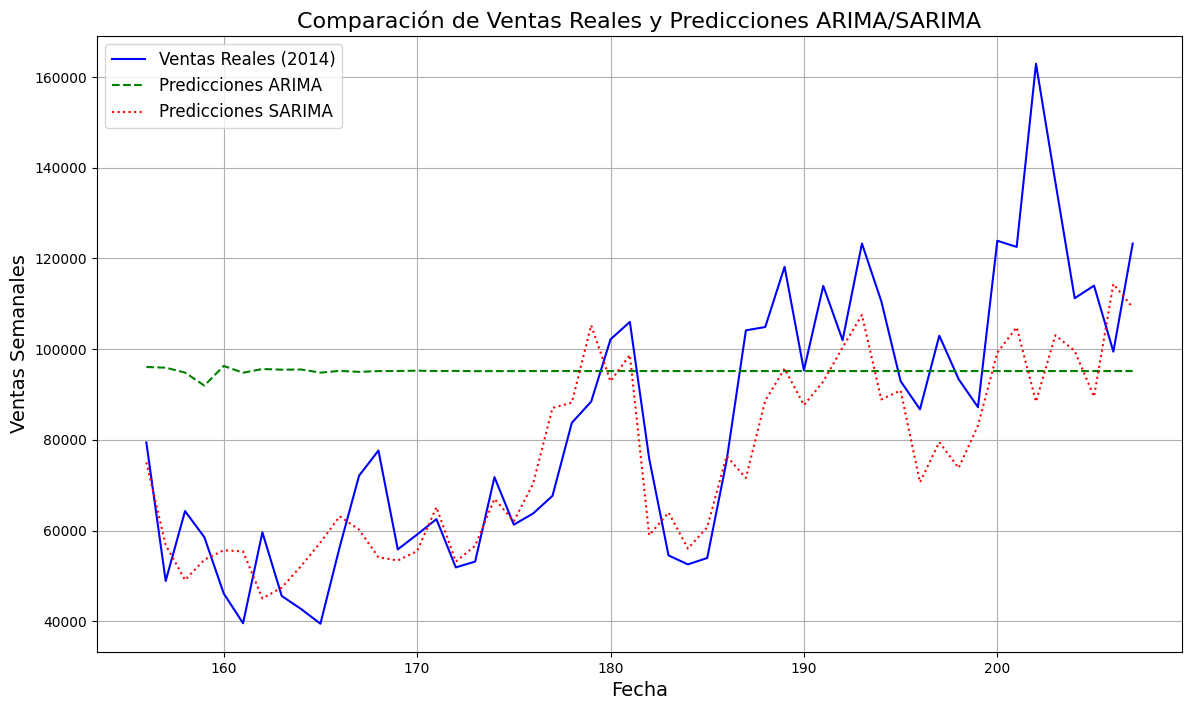

In [10]:
import matplotlib.pyplot as plt

# Asegurarnos de que las predicciones están alineadas con las fechas del conjunto de prueba
pred_arima.index = test.index
pred_sarima.index = test.index

# Gráfico de comparación
plt.figure(figsize=(14, 8))

# Ventas reales
plt.plot(test.index, test['Sales'], label='Ventas Reales (2014)', color='blue')

# Predicciones ARIMA
plt.plot(test.index, pred_arima, label='Predicciones ARIMA', color='green', linestyle='--')

# Predicciones SARIMA
plt.plot(test.index, pred_sarima, label='Predicciones SARIMA', color='red', linestyle=':')

# Detalles del gráfico
plt.title("Comparación de Ventas Reales y Predicciones ARIMA/SARIMA", fontsize=16)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Ventas Semanales", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()


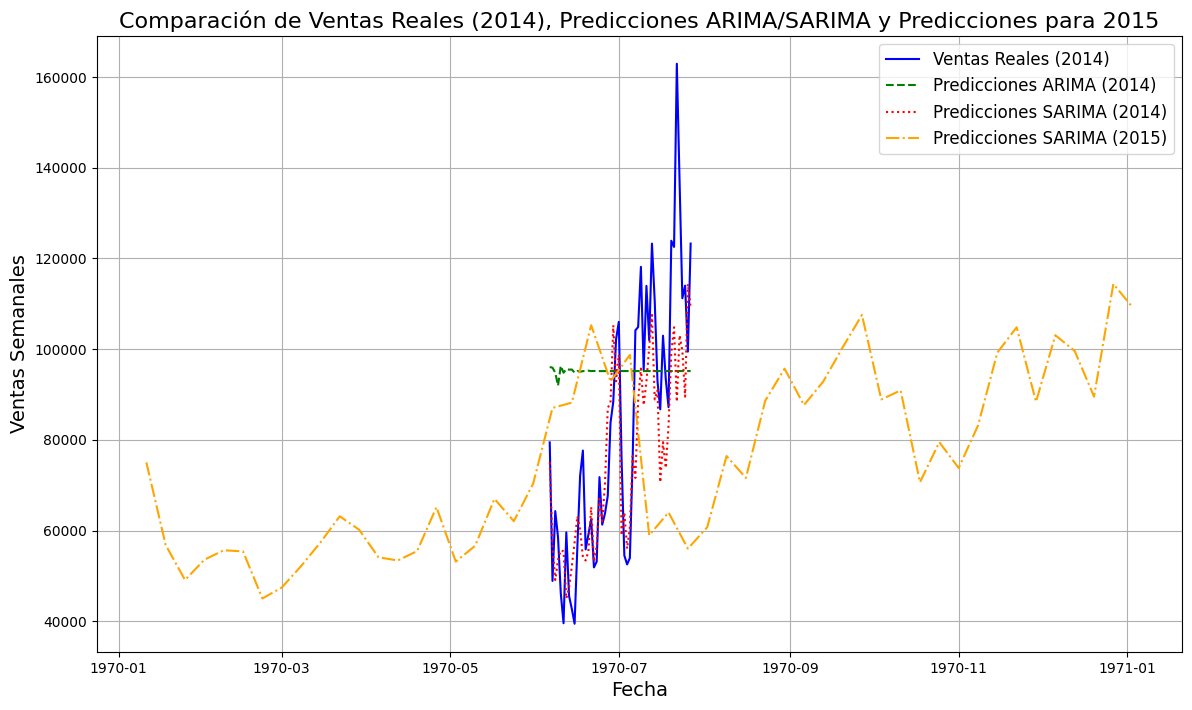

In [11]:
# Generar las predicciones para 2015 (52 semanas)
last_date = pd.to_datetime(test.index[-1])  # Convertir la última fecha a datetime
pred_2015.index = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=52, freq='W-SUN')

# Gráfico de comparación
plt.figure(figsize=(14, 8))

# Ventas reales (2014)
plt.plot(test.index, test['Sales'], label='Ventas Reales (2014)', color='blue')

# Predicciones ARIMA (2014)
plt.plot(test.index, pred_arima, label='Predicciones ARIMA (2014)', color='green', linestyle='--')

# Predicciones SARIMA (2014)
plt.plot(test.index, pred_sarima, label='Predicciones SARIMA (2014)', color='red', linestyle=':')

# Predicciones SARIMA (2015)
plt.plot(pred_2015.index, pred_2015, label='Predicciones SARIMA (2015)', color='orange', linestyle='-.')

# Detalles del gráfico
plt.title("Comparación de Ventas Reales (2014), Predicciones ARIMA/SARIMA y Predicciones para 2015", fontsize=16)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Ventas Semanales", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()


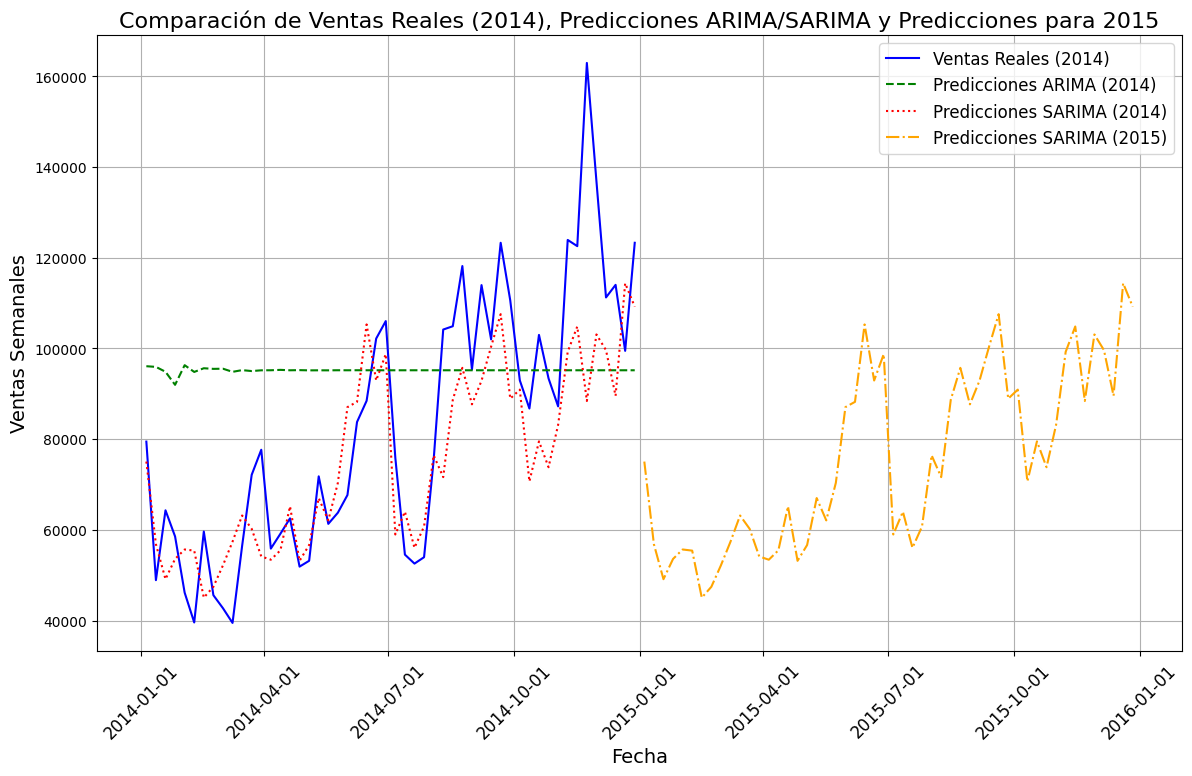

In [12]:
date_range_2014 = pd.date_range(start='2014-01-01', end='2014-12-31', freq='W')
date_range_2015 = pd.date_range(start='2015-01-01', end='2015-12-31', freq='W')  # Ajustar el rango de fechas

# Asignar el índice de fechas al conjunto de predicciones de 2015
test.index = date_range_2014
pred_2015.index = date_range_2015
# Gráfico de comparación
plt.figure(figsize=(14, 8))

# Ventas reales (2014)
plt.plot(test.index, test['Sales'], label='Ventas Reales (2014)', color='blue')

# Predicciones ARIMA (2014)
plt.plot(test.index, pred_arima, label='Predicciones ARIMA (2014)', color='green', linestyle='--')

# Predicciones SARIMA (2014)
plt.plot(test.index, pred_sarima, label='Predicciones SARIMA (2014)', color='red', linestyle=':')

# Predicciones SARIMA (2015)
plt.plot(pred_2015.index, pred_2015, label='Predicciones SARIMA (2015)', color='orange', linestyle='-.')

# Detalles del gráfico
plt.title("Comparación de Ventas Reales (2014), Predicciones ARIMA/SARIMA y Predicciones para 2015", fontsize=16)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Ventas Semanales", fontsize=14)
plt.legend(fontsize=12)
plt.grid()

# Ajustar el formato del eje x para mostrar 2014 y 2015
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, fontsize=12)
plt.show()


In [13]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Definir el espacio de parámetros
p = d = q = range(0, 3)  # Orden para (p,d,q)
P = D = Q = range(0, 2)  # Orden para (P,D,Q)
seasonal_period = [52]  # Periodo estacional

# Generar todas las combinaciones posibles de parámetros
param_combinations = list(itertools.product(p, d, q))
seasonal_combinations = list(itertools.product(P, D, Q, seasonal_period))

# Inicializar variables para almacenar el mejor modelo
best_aic = float('inf')
best_params = None
best_model = None

# Búsqueda de hiperparámetros
for param in param_combinations:
    for seasonal_param in seasonal_combinations:
        try:
            # Entrenar el modelo SARIMAX con los parámetros actuales
            model = SARIMAX(
                train['Sales'],
                order=param,
                seasonal_order=seasonal_param,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            model_fit = model.fit(disp=False)
            
            # Evaluar el modelo usando AIC
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_params = (param, seasonal_param)
                best_model = model_fit
        except Exception as e:
            continue

# Imprimir los mejores parámetros encontrados
print("Mejores parámetros:", best_params)
print("Mejor AIC:", best_aic)

# Predecir usando el mejor modelo
pred = best_model.forecast(steps=len(test))


c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Guillem\AppDa

Mejores parámetros: ((2, 2, 2), (0, 1, 1, 52))
Mejor AIC: 1043.807924158313


In [15]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Asegúrate de que tus datos de entrenamiento (train) y prueba (test) ya están divididos
# Usa la columna correcta para las fechas (en este caso se asume 'Fecha')

# Convertir la columna de fecha a tipo datetime, si no está ya en ese formato
train['Fecha'] = pd.to_datetime(train['Fecha'])
test['Fecha'] = pd.to_datetime(test['Fecha'])

# Extraer el año y la semana de la fecha
train['Year'] = train['Fecha'].dt.year
train['Week'] = train['Fecha'].dt.isocalendar().week
test['Year'] = test['Fecha'].dt.year
test['Week'] = test['Fecha'].dt.isocalendar().week

# Filtrar los datos para el entrenamiento y la prueba (2011-2013 para entrenamiento y 2014-2015 para prueba)
train_filtered = train[(train['Year'] >= 2011) & (train['Year'] <= 2013)]
test_filtered = test[(test['Year'] >= 2014) & (test['Year'] <= 2015)]

# Supongamos que los mejores parámetros obtenidos del ajuste anterior son:
best_param = (2, 2, 2)  # Estos son solo ejemplos, debes usar los parámetros optimizados
best_seasonal_param = (0, 1, 1, 52)  # Estos son solo ejemplos, debes usar los parámetros optimizados

# Reentrenar el modelo SARIMAX con los mejores parámetros obtenidos
model_sarima_final = SARIMAX(
    train_filtered['Sales'],
    order=best_param,
    seasonal_order=best_seasonal_param,
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Ajustar el modelo
model_sarima_fit_final = model_sarima_final.fit()

# Predicciones para 2014 y 2015
pred_sarima_final = model_sarima_fit_final.forecast(steps=len(test_filtered))

# Evaluar el modelo con el RMSE
rmse = np.sqrt(mean_squared_error(test_filtered['Sales'], pred_sarima_final))
print(f'RMSE para los datos de 2014 y 2015: {rmse}')

# Visualizar las predicciones vs los datos reales
plt.figure(figsize=(10, 6))
plt.plot(test_filtered['Fecha'], test_filtered['Sales'], label='Ventas reales', color='blue')
plt.plot(test_filtered['Fecha'], pred_sarima_final, label='Predicciones SARIMAX', color='red')
plt.title('Predicciones de ventas para 2014 y 2015')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()


KeyError: 'Fecha'

In [20]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Asumir que el conjunto de datos 'train' y 'test' ya está preprocesado correctamente
# Reentrenar el modelo SARIMAX con los mejores parámetros obtenidos
best_param = (2, 2, 2)  # Los mejores parámetros de la búsqueda
best_seasonal_param = (0, 1, 1, 52)  # Los mejores parámetros estacionales

# Establecer la columna de fechas como índice para que SARIMAX pueda trabajar con fechas
train['Order Date'] = pd.to_datetime(train['Order Date'])
test['Order Date'] = pd.to_datetime(test['Order Date'])
train.set_index('Order Date', inplace=True)
test.set_index('Order Date', inplace=True)

# Filtrar los datos de entrenamiento (2011-2013) y prueba (2014-2015)
train_filtered = train[(train.index.year >= 2011) & (train.index.year <= 2013)]
test_filtered = test[(test.index.year >= 2014) & (test.index.year <= 2015)]

# Crear el modelo SARIMAX con los parámetros obtenidos
model_sarima = SARIMAX(
    train_filtered['Sales'],
    order=best_param,
    seasonal_order=best_seasonal_param,
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Ajustar el modelo SARIMAX
model_sarima_fit = model_sarima.fit()

# Realizar las predicciones sobre el conjunto de prueba (2014-2015)
pred_sarima = model_sarima_fit.forecast(steps=len(test_filtered))

# Evaluar el modelo con RMSE y MAE
rmse_sarima = np.sqrt(mean_squared_error(test_filtered['Sales'], pred_sarima))
mae_sarima = mean_absolute_error(test_filtered['Sales'], pred_sarima)

# Imprimir los resultados de las métricas
print(f"SARIMA RMSE: {rmse_sarima}")
print(f"SARIMA MAE: {mae_sarima}")


KeyError: 'Order Date'

In [21]:
import pandas as pd

# Cargar el archivo
file_path = './data/orders_orders.xlsx'
df = pd.read_excel(file_path)

# Ver rango de fechas
print("Rango de fechas:", df['Order Date'].min(), "a", df['Order Date'].max())

Rango de fechas: 2011-01-01 00:00:00 a 2014-12-31 00:00:00


In [22]:
# Agregar la columna 'Week' basada en la fecha
df['Year'] = df['Order Date'].dt.year
df['Week'] = df['Order Date'].dt.isocalendar().week

# Resumir las ventas por semana
df_weekly = df.groupby(['Year', 'Week'])['Sales'].sum().reset_index()

# Separar en train (2011-2013) y test (2014)
train = df_weekly[df_weekly['Year'] < 2014]
test = df_weekly[df_weekly['Year'] == 2014]

In [24]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error





# Limitar el conjunto de datos de 2011-2013 para el entrenamiento
train_filtered = train[(train['Year'] >= 2011) & (train['Year'] <= 2013)]
# Limitar el conjunto de datos de 2014-2015 para la prueba
test_filtered = test[(test['Year'] >= 2014) & (test['Year'] <= 2015)]

# Reentrenar el modelo SARIMAX con los mejores parámetros obtenidos
best_param, best_seasonal_param = best_params  # Usar los mejores parámetros de la búsqueda anterior

model_sarima_final = SARIMAX(
    train_filtered['Sales'],
    order=best_param,
    seasonal_order=best_seasonal_param,
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Ajustar el modelo
model_sarima_fit_final = model_sarima_final.fit()

# Predicciones para 2014 y 2015
pred_sarima_final = model_sarima_fit_final.forecast(steps=len(test_filtered))

# Evaluar el modelo con el RMSE o MAE
rmse = np.sqrt(mean_squared_error(test_filtered['Sales'], pred_sarima_final))
print(f'RMSE para los datos de 2014 y 2015: {rmse}')




c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RMSE para los datos de 2014 y 2015: 16428.427674564464


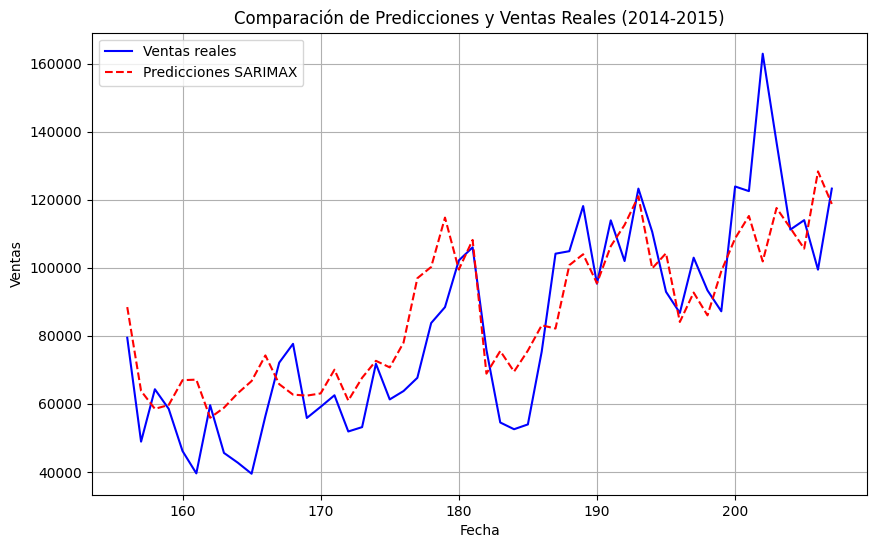

In [25]:
import matplotlib.pyplot as plt

# Visualizar las predicciones vs los datos reales para 2014 y 2015
plt.figure(figsize=(10, 6))
plt.plot(test_filtered.index, test_filtered['Sales'], label='Ventas reales', color='blue')
plt.plot(test_filtered.index, pred_sarima_final, label='Predicciones SARIMAX', color='red', linestyle='--')
plt.title('Comparación de Predicciones y Ventas Reales (2014-2015)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.show()


ValueError: x and y must have same first dimension, but have shapes (0,) and (52,)

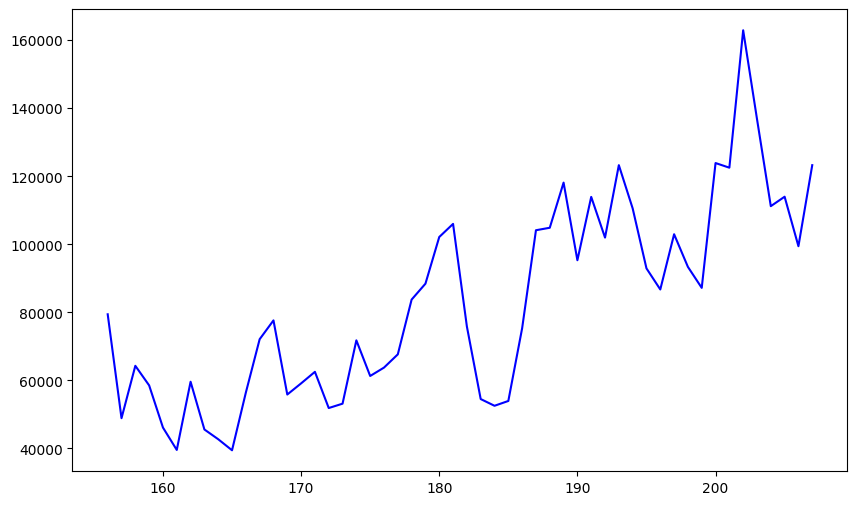

In [26]:
import matplotlib.pyplot as plt

# Filtrar los datos de 2015
test_2015 = test_filtered[test_filtered['Year'] == 2015]

# Visualizar las predicciones vs los datos reales para 2014 y 2015
plt.figure(figsize=(10, 6))
plt.plot(test_filtered.index, test_filtered['Sales'], label='Ventas reales 2014-2015', color='blue')
plt.plot(test_2015.index, pred_sarima_final[-len(test_2015):], label='Predicciones SARIMAX 2015', color='red', linestyle='--')
plt.title('Comparación de Predicciones y Ventas Reales (2014-2015)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.show()


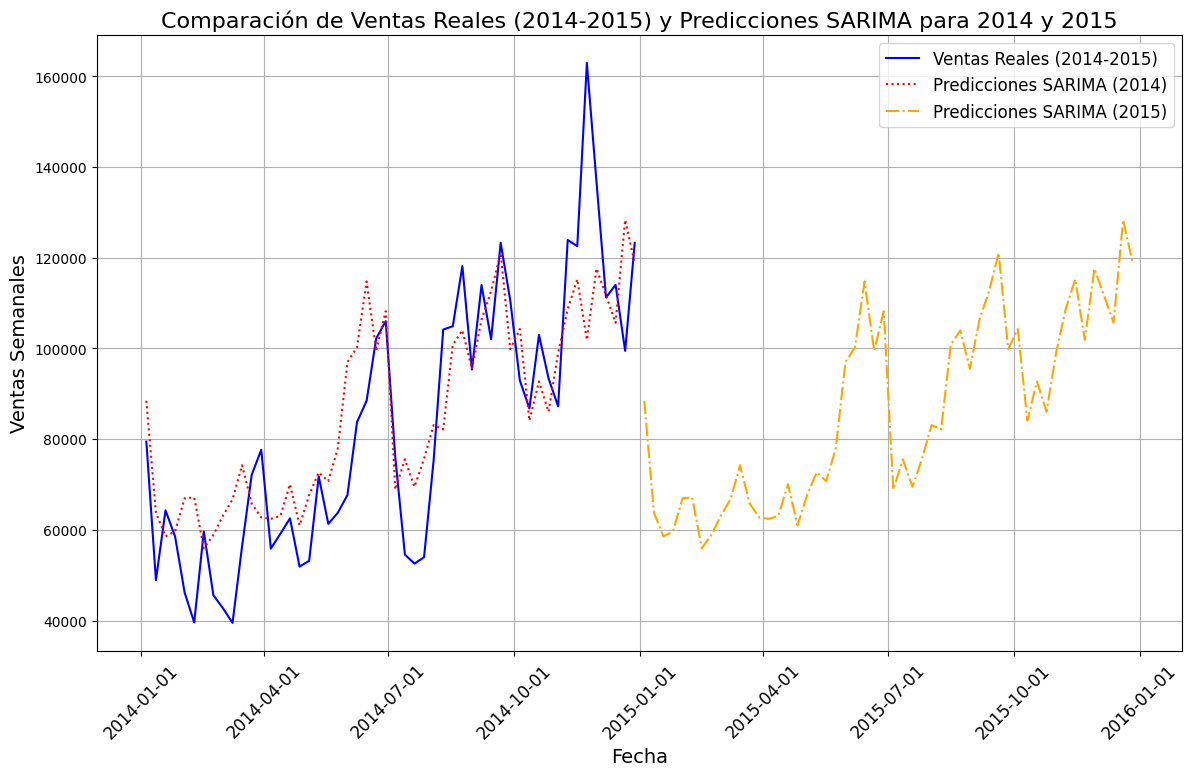

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Crear el rango de fechas para 2014 y 2015 (semanal)
date_range_2014 = pd.date_range(start='2014-01-01', end='2014-12-31', freq='W')
date_range_2015 = pd.date_range(start='2015-01-01', end='2015-12-31', freq='W')

# Asignar el índice de fechas al conjunto de predicciones de 2015
test_filtered.index = date_range_2014
pred_sarima_final.index = date_range_2015  # Asegurarse que las predicciones tienen el índice de 2015

# Gráfico de comparación
plt.figure(figsize=(14, 8))

# Ventas reales (2014 y 2015)
plt.plot(test_filtered.index, test_filtered['Sales'], label='Ventas Reales (2014-2015)', color='blue')

# Predicciones SARIMA (2014)
plt.plot(test_filtered.index, pred_sarima_final[:len(test_filtered)], label='Predicciones SARIMA (2014)', color='red', linestyle=':')

# Predicciones SARIMA (2015)
plt.plot(pred_sarima_final.index, pred_sarima_final, label='Predicciones SARIMA (2015)', color='orange', linestyle='-.')

# Detalles del gráfico
plt.title("Comparación de Ventas Reales (2014-2015) y Predicciones SARIMA para 2014 y 2015", fontsize=16)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Ventas Semanales", fontsize=14)
plt.legend(fontsize=12)
plt.grid()

# Ajustar el formato del eje x para mostrar las fechas correctamente
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, fontsize=12)

plt.show()


In [ ]:
# Predicción con los nuevos parámetros
pred_sarima_best = best_model_sarima_fit.forecast(steps=len(test))

# Evaluar con RMSE y MAE
rmse_best = np.sqrt(mean_squared_error(test['Sales'], pred_sarima_best))
mae_best = mean_absolute_error(test['Sales'], pred_sarima_best)

print(f"Nuevo modelo SARIMA RMSE: {rmse_best}, MAE: {mae_best}")
